In [1]:
#importing libraries
import pprint
import google.generativeai as palm
import pandas as pd

In [2]:
#add your api key here
palm.configure(api_key='_your_key')

In [3]:
# We are working with Generate Text model only
models = [m for m in palm.list_models() if 'generateText' in m.supported_generation_methods]
model = models[0].name

In [4]:
#function to call bard api and get prompt response
def palmresponse(prompt):
    completion = palm.generate_text(
    model=model,
    prompt=prompt,
    temperature=0,
    max_output_tokens=800)

    return completion.result

In [5]:
# function to convert the string output to pandas dataframe
def debtequitydf(bard):
    import sys
    if sys.version_info[0] < 3: 
        from StringIO import StringIO
    else:
        from io import StringIO

    TESTDATA = StringIO(bard)
    df = pd.read_csv(TESTDATA, sep="|")
    return df.iloc[1:,1:-1]


In [15]:
#function to generate prompt for different companies
def bardoutcome(company):
    #add your prompt here
    prompt ="based on these fields -  debt to equity ratio, trailingeps, total revenue, return on equity, ebit, \
    quick ratio and current ratio for "+company + " from 2013 to 2023  will "+company +" be a good company to invest in now and \
    how much % return and value on 1000 usd a person can get by investing in it"

    return palmresponse(prompt)


In [7]:
#function to perform sentiment analysis
import textblob
def sentiment_analysis(t1):
    blob = textblob.TextBlob(t1)

    # Get the sentiment polarity of the text.
    sentiment_polarity = blob.sentiment.polarity
    if sentiment_polarity> 0:
        return "Based on sentiment analysis of the response, it looks like a positive response with polarity of " + str(sentiment_polarity),'Yes'
    elif sentiment_polarity < 0:
        return "Based on sentiment analysis of the response, it looks like a negative response with polarity of " + str(sentiment_polarity),'No'
    if sentiment_polarity== 0:
        return "Based on sentiment analysis of the response, it looks like a neutral sentiment with polarity of " + str(sentiment_polarity),'No'


In [8]:
#function to remove stopwords and generate bag of words
import nltk

def remove_stopwords(string):
    # Create a set of stopwords.
    stopwords = set(nltk.corpus.stopwords.words('english'))
    # Split the string into a list of words.
    words = string.split()
    # Remove the stopwords from the list of words.
    filtered_words = [word for word in words if word not in stopwords]
    # Join the filtered words back into a string.
    filtered_string = ' '.join(filtered_words)
    # Return the filtered string.
    return filtered_string

In [9]:
#empty dataframe to store result
final_data=pd.DataFrame(columns=['Company_name','bard_outcome', "Investment_Y/N","Sentiment_of_investment","Latest_news","sentiment_of_latest_news","past_news","highest_match","sentiment_of_match"],index=range(7))

In [42]:

def complete_process(company_name,dates):
    bard_outcome=bardoutcome(company_name)
    sentiment_bard=sentiment_analysis(bardoutcome(company_name))
    #print(sentiment_bard)
    prompt ="latest wall street journal news for "+company_name
    t1=palmresponse(prompt)
    #print(t1)
    #print("This is the latest news only headline in wall street journal for "+ company_name)
    #t1=t1.split("**")[1]
    #print(t1)
    s1,flag=sentiment_analysis(t1)
    #print(s1)
    
    from io import StringIO
    df = pd.read_csv(StringIO(palmresponse("pull " + company_name +" news from wall street journal only for these dates " + \
                                           dates +  " in tabular format")), sep="|")
    df=df.iloc[1:,1:-1]
    #print(df)
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=50)

    # Transform the texts into TF-IDF vectors.
    hist_vector = vectorizer.fit_transform(df.iloc[:,1].apply(lambda x: remove_stopwords(x)))
    #print(hist_vector)
    #print("hist_vector")
    current_vector=vectorizer.transform(pd.Series(t1).apply(lambda x: remove_stopwords(x)))
    #print(current_vector)
    from sklearn.metrics.pairwise import cosine_similarity
    cos=cosine_similarity( hist_vector,current_vector)
    index_highest=pd.DataFrame(cos).idxmax()[0]
    s2=sentiment_analysis(df.iloc[index_highest,2])
    #print(index_highest)
    #print(s2)
    
    return bard_outcome, flag,sentiment_bard, t1,s1,df.iloc[:,1],df.iloc[index_highest,1],s2

    

In [20]:
final_data.iloc[0,0]='Apple'

In [43]:
final_data.iloc[0,1:]=complete_process('apple','August 15 2022, July 28 2023, October 30 2020, January 5 2023')

In [59]:
final_data.iloc[2,1:]['sentiment_of_match']#.iloc[1]
#**Apple shares rise after strong quarterly results**

('Based on sentiment analysis of the response, it looks like a negative response with polarity of -0.05',
 'No')

In [22]:
final_data.iloc[1,0]='Amazon'

In [23]:
final_data.iloc[1,1:]=complete_process('Amazon','March 29 2022,July 31 2023,November 2 ,2020, January 5 2023')

In [12]:
final_data.iloc[2,0]='Tesla'

In [45]:
final_data.iloc[2,1:]=complete_process('Tesla',' November 4 2021,April 4 2022,Friday October 30 2020,Tuesday January 3 2023')

In [24]:
final_data.iloc[3,0]='Meta'

In [29]:
final_data.iloc[3,1:]=complete_process('Meta','9/7/21,7/28/23,11/2/22,3/11/22')

In [26]:
final_data.iloc[4,0]='Pfizer'

In [27]:
final_data.iloc[4,1:]=complete_process('Pzifer','November 9 2020 - November 25 2020,November 2 2021 - November 5 2021, \
May 22 2023 - May 31 2023')

In [30]:
final_data.iloc[5,0]='Moderna'

In [31]:
final_data.iloc[5,1:]=complete_process('Moderna','June 18 2021 - July 28 2021,November 11 2021 - November 29 2021, \
January 10 2022 - January 27 2022')

In [32]:
final_data.iloc[6,0]='ExxonMobil'

final_data.iloc[6,1:]=complete_process('ExxonMobil','December 20 2021 - February 7 2022,June 8 2022 - July 14 2022,\
March 17 2023 - April 28 2023')

In [34]:
final_data.to_csv("exp_mini1.csv")

In [19]:
final_data.iloc[2]['Latest_news']

"Tesla shares fall after CEO Elon Musk says he's terminating Twitter deal"

In [43]:
final_data['Investment']=[10,10,-5,-5,10,14,-5]
#['Yes','Yes','No','No','Yes','Yes','No']#

<function matplotlib.pyplot.show(close=None, block=None)>

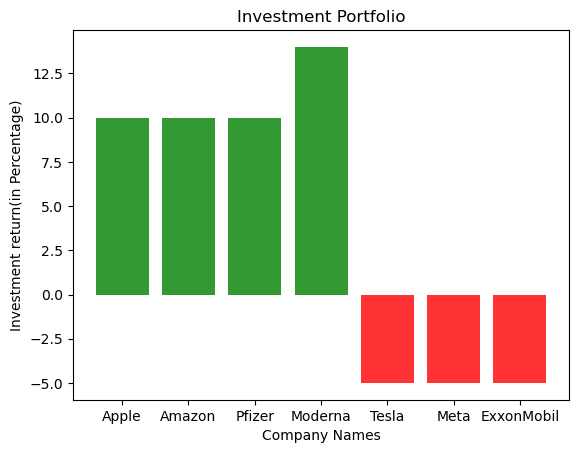

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.bar(final_data[final_data['Investment']>0]['Company_name'],final_data[final_data['Investment']>0]['Investment'], color='green', alpha=0.8)

ax.bar(final_data[final_data['Investment']<0]['Company_name'],final_data[final_data['Investment']<0]['Investment'], color='red', alpha=0.8)
ax.set_title('Investment Portfolio')
ax.set_xlabel('Company Names')
ax.set_ylabel('Investment return(in Percentage)')
plt.show

In [ ]:
import wordcloud
wordcloud = wordcloud.WordCloud(background_color='white')
wordcloud.generate(final_data.iloc[2]['Latest_news'])
wordcloud.to_file('tesla.png')
